In [1]:
import pandas as pd
import pyarrow.parquet as pq
import numpy as np
import datetime

from pyspark import SparkContext, SparkConf
from pyspark.sql import SparkSession, Row, SQLContext
from pyspark.sql.types import *
import pyspark.sql.functions as f
from pyspark.storagelevel import StorageLevel

In [3]:
conf = SparkConf().setMaster("local[*]").setAppName('ml')
sc = SparkContext(conf=conf)

ss = SparkSession.builder.getOrCreate()

ss.conf.set("spark.executor.memory", '7g')
ss.conf.set('spark.executor.cores', '8')
ss.conf.set('spark.cores.max', '10')
ss.conf.set("spark.driver.memory", '8g')

# Preprocessing 
## Reduce sizes of datasets

In [3]:
utc_date_func = f.udf(
    lambda x: datetime.datetime.utcfromtimestamp(x / 1000).date(), DateType())

### Sessions

In [4]:
sessions_df = ss.read.csv("/mnt/data/sessions.csv", header=True, sep=",").\
              filter("is_session=='true' AND is_developer=='false' \
                     AND is_wau=='false' AND is_mau=='false'"                                                             ).\
              drop('is_session', 'is_developer', 'is_wau', 'is_mau', 'app_id').\
              persist(StorageLevel.DISK_ONLY)

In [5]:
sessions_df2 = sessions_df.\
               withColumn('start_timestamp_int', 
                          sessions_df['start_timestamp'].cast(LongType())).\
               drop('start_timestamp')
sessions_df2 = sessions_df2.\
               withColumn('user_created_timestamp_int',
                          sessions_df2['user_created_timestamp'].cast(LongType())).\
               drop('user_created_timestamp')

In [6]:
sessions_df3 = sessions_df2.\
               withColumn('start_time',
                          utc_date_func(sessions_df2['start_timestamp_int'])).\
               drop('start_timestamp_int')
sessions_df3 = sessions_df3.\
               withColumn('user_created_time',
                          utc_date_func(sessions_df3['user_created_timestamp_int'])).\
               drop('user_created_timestamp_int').persist(StorageLevel.DISK_ONLY)

In [7]:
sessions_df3 = sessions_df3.\
               withColumn('start_date', sessions_df3['start_time'].cast(StringType())).\
               drop('start_time').persist(StorageLevel.DISK_ONLY)
sessions_df3 = sessions_df3.\
               withColumn('user_created_date', sessions_df3['user_created_time'].cast(StringType())).\
               drop('user_created_time').persist(StorageLevel.DISK_ONLY)

In [8]:
sessions_df3.select('start_date', 'user_created_date').show(5)

+----------+-----------------+
|start_date|user_created_date|
+----------+-----------------+
|2018-11-14|       2018-10-07|
|2018-12-02|       2018-10-07|
|2018-10-10|       2018-10-07|
|2018-10-21|       2018-10-07|
|2018-11-19|       2018-10-07|
+----------+-----------------+
only showing top 5 rows



In [9]:
sessions_df3.printSchema()

root
 |-- session_id: string (nullable = true)
 |-- timezone: string (nullable = true)
 |-- timezone_offset: string (nullable = true)
 |-- previous_sessions_duration: string (nullable = true)
 |-- is_user_first_session: string (nullable = true)
 |-- country: string (nullable = true)
 |-- region: string (nullable = true)
 |-- city: string (nullable = true)
 |-- latitude: string (nullable = true)
 |-- longitude: string (nullable = true)
 |-- locale: string (nullable = true)
 |-- os_name: string (nullable = true)
 |-- session_index: string (nullable = true)
 |-- device_id: string (nullable = true)
 |-- user_id_hash: string (nullable = true)
 |-- start_date: string (nullable = true)
 |-- user_created_date: string (nullable = true)



In [29]:
user_sessions = sessions_df3.select('user_id_hash').distinct()
session_sessions = sessions_df3.select('session_id').distinct()

In [31]:
# convert to pandas dataframe and save to local for backup if needed
# user_sessions_csv = user_sessions.toPandas()
# session_sessions_csv = session_sessions.toPandas()

# user_sessions_csv.to_csv('./newdata/user_sessions.csv', index=False)
# session_sessions_csv.to_csv('./newdata/session_sessions.csv', index=False)

### Events

In [17]:
events_df = ss.read.csv(
    "/mnt/data/events.csv", header=True, sep=",").drop('app_id')

In [18]:
events_df.printSchema()

root
 |-- session_id: string (nullable = true)
 |-- event: string (nullable = true)
 |-- event_timestamp: string (nullable = true)
 |-- event_value: string (nullable = true)
 |-- user_id_hash: string (nullable = true)



In [20]:
events_df2 = events_df.\
    withColumn('event_timestamp_int',
               events_df['event_timestamp'].cast(LongType())).\
    drop('event_timestamp')
events_df3 = events_df2.\
    withColumn('event_time',
               utc_date_func(events_df2['event_timestamp_int'])).\
    drop('event_timestamp_int').persist(StorageLevel.DISK_ONLY)

In [21]:
events_df3 = events_df3.\
    withColumn('event_date', events_df3['event_time'].cast(StringType())).\
    drop('event_time').persist(StorageLevel.DISK_ONLY)

In [22]:
events_df3.select('event_date').show(5)

+----------+
|event_date|
+----------+
|2018-11-14|
|2018-11-14|
|2018-11-02|
|2018-12-02|
|2018-12-02|
+----------+
only showing top 5 rows



In [23]:
events_df3.printSchema()

root
 |-- session_id: string (nullable = true)
 |-- event: string (nullable = true)
 |-- event_value: string (nullable = true)
 |-- user_id_hash: string (nullable = true)
 |-- event_date: string (nullable = true)



In [36]:
user_events = events_df3.select('user_id_hash').distinct()
session_events = events_df3.select('session_id').distinct()

In [37]:
# convert to pandas dataframe and save to local for backup if needed

# user_events_csv = user_events.toPandas()
# session_events_csv = session_events.toPandas()

# user_events_csv.to_csv('./newdata/user_events.csv', index=False)
# session_events_csv.to_csv('./newdata/session_events.csv', index=False)

### Attributes

In [3]:
attributes = sc.textFile("attributes.csv", 100).\
             map(lambda x: [x.split(',')[0], x.split(',')[1], x.split(',')[2],
                            ','.join(x.split(',')[3:-1]).replace("\"","").replace("\\",""),
                            x.split(',')[-1]])

In [4]:
header = attributes.first()
attributes = attributes.filter(lambda x: 'app_id' not in x)

fields = [StructField(field_name, StringType(), True) for field_name in header]
schema = StructType(fields)

In [5]:
attributes_df = ss.createDataFrame(attributes, schema=schema).\
                persist(StorageLevel.DISK_ONLY)
attributes_df2 = attributes_df.drop('app_id').\
                 persist(StorageLevel.DISK_ONLY)

In [6]:
# make the action to be taken
attributes_df2.show(5)

+-------------------+---------+--------------------+--------------------+
|         session_id|attribute|     attribute_value|        user_id_hash|
+-------------------+---------+--------------------+--------------------+
|2201961907282901522|        0|                   1|9943447915df3a45f...|
|2201961907282901522|        1|                   1|9943447915df3a45f...|
|2201961907282901522|        3|                   0|9943447915df3a45f...|
|2201961907282901522|        4|                0.00|9943447915df3a45f...|
|2201961907282901522|        5|romance_the_royal...|9943447915df3a45f...|
+-------------------+---------+--------------------+--------------------+
only showing top 5 rows



In [42]:
# Total number of rows in this data set
# attributes_df.count() # 185590092 rows

In [43]:
user_attributes = attributes_df2.select('user_id_hash').distinct()
session_attributes = attributes_df2.select('session_id').distinct()
# user_attributes.write.format("csv").save("./newdata/user_attributes.csv")
# print(f"The total number of user id in this data set is {user_attributes.count()}.")

In [30]:
# convert to pandas dataframe if needed
# user_attributes_csv = user_attributes.toPandas()
# session_attributes_csv = session_attributes.toPandas()

# save to local as csv file for backup if needed
# user_attributes_csv.to_csv('./newdata/user_attributes.csv',index=False)
# session_attributes_csv.to_csv('./newdata/session_attributes.csv',index=False)

### Create mappings

In [46]:
# use pandas dataframe to create mappings
# user_ids = pd.concat([user_attributes_csv, user_events_csv, user_sessions_csv]).\
#            drop_duplicates()
# session_ids = pd.concat([session_attributes_csv, session_events_csv,
#                          session_sessions_csv]).\
#               drop_duplicates()

# use spark sql dataframe to create mappings
user_ids = user_attributes.union(user_events).union(user_sessions).\
           distinct().persist(StorageLevel.DISK_ONLY)
session_ids = session_attributes.union(session_events).\
              union(session_sessions).\
              distinct().persist(StorageLevel.DISK_ONLY)

In [49]:
user_ids.count()

621500

In [50]:
session_ids.count()

6510765

In [16]:
# use pandas dataframe to create mappings
# user_map = user_ids.reset_index()
# session_map = session_ids.reset_index()

# use spark sql dataframe to create mappings
user_map = user_ids.toPandas().reset_index()
session_map = session_ids.toPandas().reset_index()

user_map.columns = ['user_code', 'user_id_hash']
session_map.columns = ['session_code', 'session_id']

In [17]:
# save to local for backup
# user_map.to_csv('./newdata/user_map.csv', index=False)
# session_map.to_csv('./newdata/session_map.csv', index=False)

### create new data frame by joining

In [11]:
# pandas dataframe mappings
# user_map = pd.read_csv('./newdata/user_map.csv').set_index('user_id_hash')
# session_map = pd.read_csv('./newdata/session_map.csv').set_index('session_id')

# spark sql dataframe mappings
user_map_df = ss.read.csv('./newdata/user_map.csv', header=True, sep=",")
session_map_df = ss.read.csv('./newdata/session_map.csv', header=True, sep=",")

In [12]:
user_map_df.show(5)

+---------+--------------------+
|user_code|        user_id_hash|
+---------+--------------------+
|        0|04b6836e16e856579...|
|        1|c0421c03e84fa1c47...|
|        2|448a7de13d61c19a1...|
|        3|d44062550dc97f982...|
|        4|e476dabc758fbdfed...|
+---------+--------------------+
only showing top 5 rows



#### Sessions

In [5]:
# use pandas to join dataframes

# sessions = pd.read_csv('sessions.csv')  # raw sessions csv

# sessions = sessions[(sessions.is_session == True) &
#                     (sessions.is_developer == False) &
#                     (sessions.is_wau == False) &
#                     (sessions.is_mau == False)].\
#     drop(['app_id', 'is_wau', 'is_mau', 'is_session', 'is_developer'], axis=1)

# sessions_new = sessions.\
#                join(user_map, on='user_id_hash').\
#                join(session_map, on='session_id').\
#                drop(['session_id', 'user_id_hash'], axis=1)

In [14]:
sessions = sessions_df3.\
           join(user_map_df, 'user_id_hash', 'left').\
           join(session_map_df, 'session_id', 'left').\
           select('start_date', 'timezone', 'timezone_offset',
                  'previous_sessions_duration', 'user_created_date',
                  'is_user_first_session', 'country', 'region', 'city',
                  'latitude', 'longitude', 'locale', 'os_name',
                  'session_index', 'device_id', 'user_code', 'session_code').\
            persist(StorageLevel.DISK_ONLY)

In [15]:
sessions.show(1)

+----------+----------------+---------------+--------------------------+-----------------+---------------------+-------+------+-----+------------------+-------------------+------+----------+-------------+--------------------+---------+------------+
|start_date|        timezone|timezone_offset|previous_sessions_duration|user_created_date|is_user_first_session|country|region| city|          latitude|          longitude|locale|   os_name|session_index|           device_id|user_code|session_code|
+----------+----------------+---------------+--------------------------+-----------------+---------------------+-------+------+-----+------------------+-------------------+------+----------+-------------+--------------------+---------+------------+
|2018-12-02|America/Mazatlan|      -25200000|                  32613534|       2018-11-24|                false|     MX|   nay|tepic|21.504165649414062|-104.89459228515625| es_MX|Android OS|           44|e8aaee94-6baa-4ed...|   617387|       21760|
+---

In [16]:
# save to local as .parquet file
sessions.write.parquet("./newdata/sessions_new.parquet")

#### Events

In [60]:
events_df3.printSchema()

root
 |-- session_id: string (nullable = true)
 |-- event: string (nullable = true)
 |-- event_value: string (nullable = true)
 |-- user_id_hash: string (nullable = true)
 |-- event_time: date (nullable = true)



In [24]:
events = events_df3.\
         join(user_map_df, 'user_id_hash', 'left').\
         join(session_map_df, 'session_id', 'left').\
         select('event', 'event_value', 'event_date',
                'user_code', 'session_code').\
        persist(StorageLevel.DISK_ONLY)

In [25]:
events.show(5)

+------------------+-----------+----------+---------+------------+
|             event|event_value|event_date|user_code|session_code|
+------------------+-----------+----------+---------+------------+
|.a5027911885258752|        0.0|2018-11-21|   619184|        8448|
|.a5516611293544448|        0.0|2018-11-21|   619184|        8448|
|.a5400102822346752|        0.0|2018-11-21|   619184|        8448|
|                44|        0.0|2018-11-21|   619184|        8448|
|                 5|        0.0|2018-11-21|   619184|        8448|
+------------------+-----------+----------+---------+------------+
only showing top 5 rows



In [26]:
# save to local as .parquet file
events.write.parquet("./newdata/events_new.parquet")

#### Attributes

In [8]:
attributes = attributes_df2.\
             join(user_map_df, 'user_id_hash', 'left').\
             join(session_map_df, 'session_id', 'left').\
             select('session_code', 'attribute', 'attribute_value', 'user_code').\
            persist(StorageLevel.DISK_ONLY)

In [9]:
attributes.show(2)

+------------+---------+---------------+---------+
|session_code|attribute|attribute_value|user_code|
+------------+---------+---------------+---------+
|       21760|        0|              2|   617387|
|       21760|        1|              0|   617387|
+------------+---------+---------------+---------+
only showing top 2 rows



In [10]:
attributes.write.parquet("./newdata/attributes.parquet")

### Convert dtypes in pandas

#### sessions

In [5]:
sessions_new = pd.read_parquet('./newdata/sessions_new.parquet', engine='pyarrow')

In [13]:
sessions_new.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5165760 entries, 0 to 5165759
Data columns (total 17 columns):
start_time                    object
timezone                      object
timezone_offset               object
previous_sessions_duration    object
user_created_time             object
is_user_first_session         object
country                       object
region                        object
city                          object
latitude                      object
longitude                     object
locale                        object
os_name                       object
session_index                 object
device_id                     object
user_code                     object
session_code                  object
dtypes: object(17)
memory usage: 670.0+ MB


- deal with time data: `start_time` and `user_created_time`
- convert `previous_sessions_duration` and `timezone_offset` in seconds
- convert data type: `user_code`(uint32) and `session_code`(uint32); `latitude`(int8) and `longitude`(int16); `session_index`(uint16)
- convert object to category: `timezone`, `country`, `region`, `city`, `locale`, `device_id`

In [6]:
# convert numeric data type
sessions_new.session_index = sessions_new.session_index.astype(np.uint16)
sessions_new.user_code = sessions_new.user_code.astype(np.uint32)
sessions_new.session_code = sessions_new.session_code.astype(np.uint32)
# there are nan's in latitude and longitude
# sessions_new.latitude = sessions_new.latitude.astype(np.int8)
# sessions_new.longitude = sessions_new.longitude.astype(np.int16)

In [7]:
# convert timestamp in seconds
sessions_new.previous_sessions_duration = \
    (np.uint64(sessions_new.previous_sessions_duration)/1000).astype(np.uint32)
sessions_new.timezone_offset = \
    (np.int64(sessions_new.timezone_offset)/1000).astype(np.int32)

In [8]:
# convert longitude and latitude to float
sessions_new.latitude = sessions_new.latitude.astype(np.float64)
sessions_new.longitude = sessions_new.longitude.astype(np.float64)

In [9]:
# convert boolean to int
sessions_new.is_user_first_session = \
    sessions_new.is_user_first_session.astype('bool').astype('uint8')

In [10]:
# convert object to category
sessions_new[sessions_new.select_dtypes(include='object').columns] = \
    sessions_new[sessions_new.select_dtypes(include='object').columns].\
    astype('category')

In [11]:
sessions_new.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5165760 entries, 0 to 5165759
Data columns (total 17 columns):
start_date                    category
timezone                      category
timezone_offset               int32
previous_sessions_duration    uint32
user_created_date             category
is_user_first_session         uint8
country                       category
region                        category
city                          category
latitude                      float64
longitude                     float64
locale                        category
os_name                       category
session_index                 uint16
device_id                     category
user_code                     uint32
session_code                  uint32
dtypes: category(9), float64(2), int32(1), uint16(1), uint32(3), uint8(1)
memory usage: 282.5 MB


In [12]:
sessions_new.to_csv('./newdata/sessions_new.csv', index=False)

**Reduce memory usage of *sessions.csv* from 674.9 MB to 282.5 MB.**

#### events

In [17]:
events_new = pd.read_parquet("./newdata/events_new.parquet", engine='pyarrow')

In [29]:
events_new.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 111946597 entries, 0 to 111946596
Data columns (total 5 columns):
event           object
event_value     object
event_time      object
user_code       object
session_code    object
dtypes: object(5)
memory usage: 4.2+ GB


In [18]:
events_new.user_code = events_new.user_code.astype(np.uint32)
events_new.session_code = events_new.session_code.astype(np.uint32)

events_new.event = events_new.event.astype('category')
events_new.event_value = events_new.event_value.astype(np.float64)
events_new.event_date = events_new.event_date.astype('category')

In [19]:
events_new.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 111946597 entries, 0 to 111946596
Data columns (total 5 columns):
event           category
event_value     float64
event_date      category
user_code       uint32
session_code    uint32
dtypes: category(2), float64(1), uint32(2)
memory usage: 1.9 GB


**Reduce memory usage of *events.csv* from 4.2+ GB to 1.9 GB.**

In [20]:
events_new.to_csv('./newdata/events_new.csv', index=False)

####  attributes

In [37]:
attributes_new = pd.read_parquet("./newdata/attributes.parquet", engine='pyarrow')

In [38]:
attributes_new.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 185590092 entries, 0 to 185590091
Data columns (total 4 columns):
session_code       object
attribute          object
attribute_value    object
user_code          object
dtypes: object(4)
memory usage: 5.5+ GB


In [40]:
attributes_new.session_code = attributes_new.session_code.astype(np.uint32)
attributes_new.user_code = attributes_new.user_code.astype(np.uint32)
attributes_new.attribute = attributes_new.attribute.astype(np.uint8)

attributes_new.attribute_value = \
    attributes_new.attribute_value.astype('category')

In [41]:
attributes_new.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 185590092 entries, 0 to 185590091
Data columns (total 4 columns):
session_code       uint32
attribute          uint8
attribute_value    category
user_code          uint32
dtypes: category(1), uint32(2), uint8(1)
memory usage: 2.3 GB


**Reduce memory usage of *attributes.csv* from 5.5+ GB to 2.3 GB.**

In [ ]:
attributes_new.to_csv('./newdata/attributes_new.csv', index=False)

# EDA

In [2]:
import pandas as pd
import pyarrow.parquet as pq
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

import datetime

import warnings
warnings.filterwarnings('ignore')

## sessions

In [73]:
sessions_dtypes = {'start_date': 'category', 
                   'timezone': 'category', 
                   'timezone_offset': np.int32,
                   'previous_sessions_duration': np.uint32,
                   'user_created_date': 'category',
                   'is_user_first_session': np.uint8,
                   'country': 'category',
                   'region': 'category',
                   'city': 'category',
                   'latitude': np.float64,
                   'longitude': np.float64,
                   'locale': 'category',
                   'os_name': 'category',
                   'session_index': np.uint32,
                   'device_id': 'category',
                   'user_code': np.uint32,
                   'session_code': np.uint32
                  }
sessions_new = pd.read_csv('./newdata/sessions_new.csv', dtype=sessions_dtypes)

In [74]:
sessions_new.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5165760 entries, 0 to 5165759
Data columns (total 17 columns):
start_date                    category
timezone                      category
timezone_offset               int32
previous_sessions_duration    uint32
user_created_date             category
is_user_first_session         uint8
country                       category
region                        category
city                          category
latitude                      float64
longitude                     float64
locale                        category
os_name                       category
session_index                 uint32
device_id                     category
user_code                     uint32
session_code                  uint32
dtypes: category(9), float64(2), int32(1), uint32(4), uint8(1)
memory usage: 292.3 MB


### statistical description

In [50]:
sessions_new[[
    'previous_sessions_duration', 'latitude', 'longitude', 'session_index'
]].describe()

,previous_sessions_duration,latitude,longitude,session_index
count,5.165760e+06,5.163030e+06,5.163030e+06,5.165760e+06
mean,4.375607e+04,2.938464e+01,-2.152131e+01,3.975427e+01
std,7.677649e+04,2.210644e+01,8.031817e+01,6.650301e+01
min,0.000000e+00,-5.480191e+01,-1.752049e+02,1.000000e+00
25%,3.466000e+03,2.102776e+01,-8.678160e+01,4.000000e+00
50%,1.595300e+04,3.575647e+01,-7.023116e+01,1.500000e+01
75%,5.177400e+04,4.253574e+01,3.037941e+01,4.700000e+01
max,1.956531e+06,7.822318e+01,1.784501e+02,1.404000e+03


In [76]:
print(f"The total number of countries is {len(sessions_new.country.unique())}.")
print(f"The total number of regions is {len(sessions_new.region.unique())}.")
print(f"The total number of cities is {len(sessions_new.city.unique())}.")
print(f"The total number of locale is {len(sessions_new.locale.unique())}.")
print(f"The total number of os_name is {len(sessions_new.os_name.unique())}.")
print(f"The total number of device_id is {len(sessions_new.device_id.unique())}.")

The total number of countries is 229.
The total number of regions is 756.
The total number of cities is 31541.
The total number of locale is 1760.
The total number of os_name is 4.
The total number of device_id is 612318.


### distribution of number of new users/sessions vs date

In [57]:
user_num_created_time = sessions_new.groupby('user_created_time').\
                        user_code.nunique().\
                        reset_index()
session_num_date = sessions_new.groupby('start_time').\
                   session_code.nunique().\
                   reset_index()

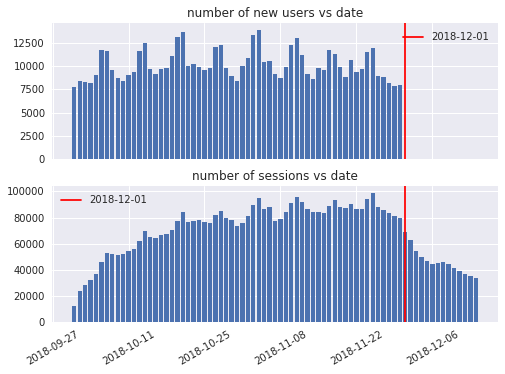

In [100]:
fig, (ax1, ax2) = plt.subplots(2, sharex=True)
ax1.bar(x=user_num_created_time.user_created_time.tolist(),
        height=user_num_created_time.user_code.tolist())
handle1 = ax1.axvline('2018-12-01', color='r')
# ax1.tick_params(axis='x', rotation=90)
ax1.set_title(label='number of new users vs date')
ax1.legend([handle1], ['2018-12-01'])
ax2.bar(x=session_num_date.start_time.tolist(),
        height=session_num_date.session_code.tolist())
handle2 = ax2.axvline('2018-12-01', color='r')
ax2.tick_params(axis='x', rotation=30)
ax2.set_title(label='number of sessions vs date')
ax2.legend([handle2], ['2018-12-01'])
plt.show()

- From the first plot, we can see s obvious pattern for the number of new users as date changes. The length of each season is 7, which indicates there is a weekly seasonality for new users' registration. This is reasonable intuitively, because there would be more new users on weekends.
- In the second plot, the same pattern appears but it seems weaker than the first one. One possible reason for this phenomena might be that the number of sessions in each day is almost ten times as the number of new users. With the same sizes of the two plots, only a little difference in the second plot would indicate a large difference in real amount. Basically, the trend in second plot is more obvious. The total number of sessions in late Sep. and early Oct. is pretty small, and there was a peak in the middle of Nov., then suddenly decreased.<br />

From the analysis above, extracting a new feature `day_of_week` would be helpful to predict the pattern of number of users and number of sessions for each day. The more new users are and the more sessions are, the more likely the purchases happen.


### distribution of `session_index`

<Figure size 1152x576 with 0 Axes>

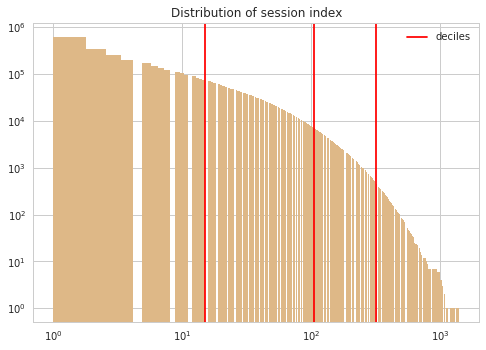

In [90]:
plt.figure(figsize=(16,8))
sns.set_style('whitegrid')
fig, ax = plt.subplots()
ax.hist(sessions_new.session_index, bins=1800, color='burlywood')
deciles = sessions_new.session_index.quantile([.5, .9, .99])
for i, pos in enumerate(deciles):
    handle = plt.axvline(pos, color='r')
ax.legend([handle], ['deciles'])
ax.set_yscale('log')
ax.set_xscale('log')
plt.title('Distribution of session index')
plt.show()

We take log transformation for the `session_index`, it turned out that although we only have the users who created the accounts between Oct 1st to Dec 1st, there are many users would have high session index, which means some of those new users have a high frequency to use the app.

### region analysis
We also want to check if geographic data is helpful.

#### longitude&latitude heatmap

In [28]:
longitude = pd.cut(
    sessions_new.longitude[(sessions_new.longitude.notnull()) &
                           (sessions_new.latitude.notnull())],
    bins=np.arange(-1.9e+02, 1.9e+02, 18),
    include_lowest=True,
    right=True)
latitude = pd.cut(
    sessions_new.latitude[(sessions_new.longitude.notnull()) &
                          (sessions_new.latitude.notnull())],
    bins=np.arange(-6e+01, 8.5e+01, 10),
    include_lowest=True,
    right=True)

In [29]:
longmap = pd.Series(longitude.sort_values().unique()).\
          reset_index().rename(columns={'index':'longidx', 0:'longitude'}).\
          set_index('longitude')
latimap = pd.Series(latitude.sort_values().unique()).\
          reset_index().rename(columns={'index':'latiidx', 0:'latitude'}).\
          set_index('latitude')

In [85]:
geography_info = pd.concat([longitude, latitude], axis=1).\
                 groupby(['longitude', 'latitude']).\
                 size().\
                 reset_index().\
                 rename(columns={0:'cnt'})
total_cnt = np.sum(geography_info.cnt)
geography_info['proportion_cnt'] = np.ceil(geography_info.cnt/total_cnt*100000)
geography_info = geography_info.join(longmap, 'longitude').join(latimap, 'latitude')

In [87]:
fake_geo = pd.DataFrame(columns=longmap.index.tolist(), 
                        index=latimap.index.tolist())
for row in geography_info.iterrows():
    fake_geo.loc[row[1]['latitude'], row[1]['longitude']] = row[1]['proportion_cnt']

In [88]:
fake_geo.replace(np.float('nan'), 0, inplace=True)

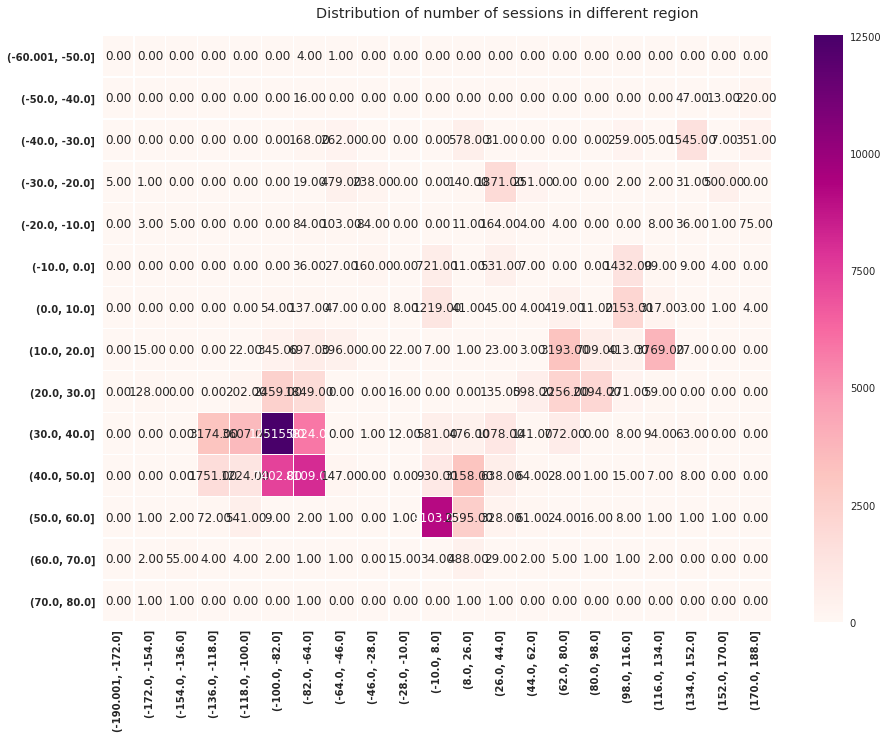

In [91]:
fig, ax = plt.subplots(figsize=(15,10))
fig.subplots_adjust(top=.94)
plt.suptitle('Distribution of number of sessions in different region')

ax.set_yticklabels(ax.get_yticklabels(), ha='right',fontsize=10, weight='bold')
ax.set_xticklabels(ax.get_xticklabels(), fontsize=10, weight='bold')
sns.heatmap(fake_geo, annot=True, fmt='.2f', linewidths=.3, 
            ax=ax, cmap='RdPu')
plt.show()

From the heatmap above, we can say that the geographic feature might be helpful in our model.

#### country

In [8]:
user_num_country = sessions_new.groupby('country').\
                   user_code.nunique().reset_index()

In [18]:
print(f'There are {user_num_country.shape[0]} countries in total.')

There are 228 countries in total.


In [22]:
user_num_country.sort_values('user_code', ascending=False).head(5)

,country,user_code
165,US,279640
52,GB,44681
72,IN,43238
126,PH,26964
26,CA,19981


In [28]:
print(f"We can see that there are {np.around(279640/np.sum(user_num_country.user_code)*100)}\
% of the users in this data set from US.")
print("We would consider the user number less than 100 would have effect in our analysis.")

We can see that there are 45.0% of the users in this data set from US.
We would consider the user number less than 100 would have effect in our analysis.


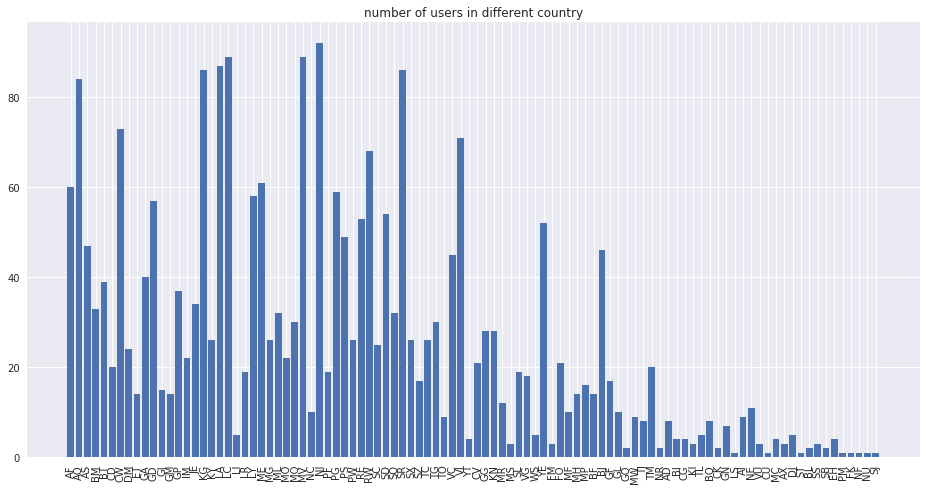

In [32]:
plt.figure(figsize=(16,8))
plt.bar(
    x=user_num_country[(user_num_country.country != 'US')
                       & (user_num_country.user_code < 100)].country.tolist(),
    height=user_num_country[(user_num_country.country != 'US') & (
        user_num_country.user_code < 100)].user_code.tolist())
plt.title('number of users in different country')
plt.xticks(rotation=90)
plt.show()

### session duration

In [78]:
duration = sessions_new.groupby(['user_code','session_code']).\
           previous_sessions_duration.mean().reset_index()

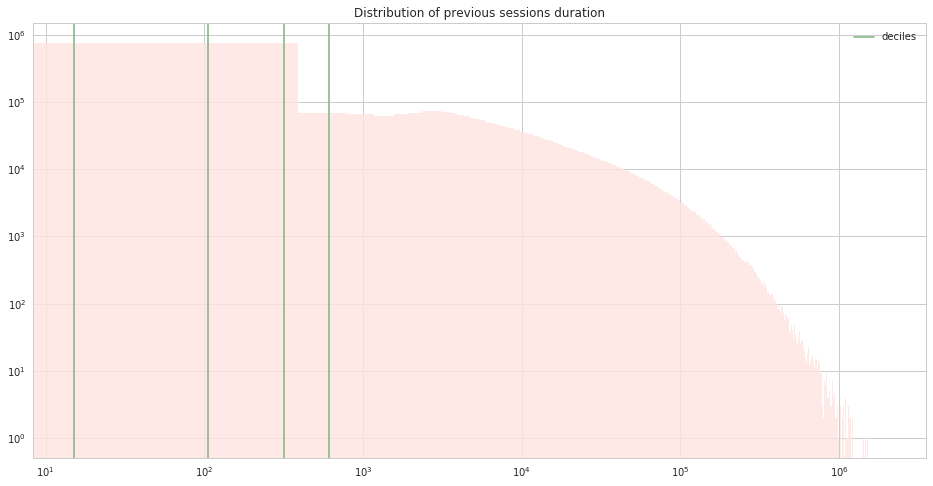

In [99]:
sns.set_style('whitegrid')
fig, ax = plt.subplots(figsize=(16,8))
ax.hist(duration.previous_sessions_duration, bins=5000, 
        color='mistyrose', alpha=0.8)
deciles = sessions_new.session_index.quantile([.5, .9, .99, .999])
for i, pos in enumerate(deciles):
    handle = plt.axvline(pos, color='darkseagreen')
ax.legend([handle], ['deciles'])
ax.set_yscale('log')
ax.set_xscale('log')
plt.title('Distribution of previous sessions duration')
plt.show()

Most of the sessions would last in 1000 seconds(because we can see that more than 99.9% sessions has less than 1000 seconds duration.

## events

In [3]:
events_dtypes = {'event': 'category',
                 'event_value': np.float64,
                 'event_date': 'category',
                 'user_code': np.uint32,
                 'session_code': np.uint32}

events_new = pd.read_csv('./newdata/events_new.csv', dtype=events_dtypes)

### events amount vs date

In [7]:
events_num_date = events_new.\
                  groupby('event_date').\
                  event.count().reset_index()

In [10]:
events_num_date.head(3)

,event_date,event
0,2018-10-01,310589
1,2018-10-02,597933
2,2018-10-03,676595


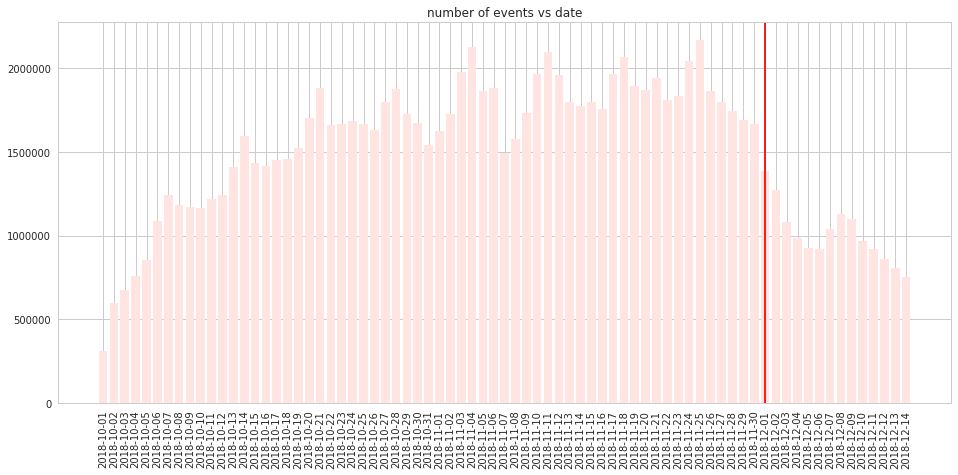

In [98]:
plt.figure(figsize=(16,7))
plt.bar(x=events_num_date.event_date.tolist(),
        height=events_num_date.event.tolist(),
        color='mistyrose')
handle = plt.axvline('2018-12-01', color='r', label='2018-12-01')
plt.tick_params(axis='x', rotation=90)
plt.title('number of events vs date')
plt.show()

The number of events vs date also shows a weekly seasonality pattern. 

### event is purchase

In [25]:
purchase = events_new[(events_new.event=='8')] 
print(f'There are {purchase.shape[0]} records of purchases.')

There are 265034 records of purchases.


In [21]:
purchase.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 265034 entries, 151 to 111946039
Data columns (total 5 columns):
event           265034 non-null category
event_value     265034 non-null float64
event_date      265034 non-null category
user_code       265034 non-null uint32
session_code    265034 non-null uint32
dtypes: category(2), float64(1), uint32(2)
memory usage: 6.6 MB


In [34]:
purchase_num = purchase.groupby('event_date').event.count().reset_index().\
               join(purchase.groupby('event_date').event_value.sum(), 'event_date')

In [35]:
purchase_num.head(3)

,event_date,event,event_value
0,2018-10-01,435,1310.154983
1,2018-10-02,1164,3426.751964
2,2018-10-03,1518,4441.380949


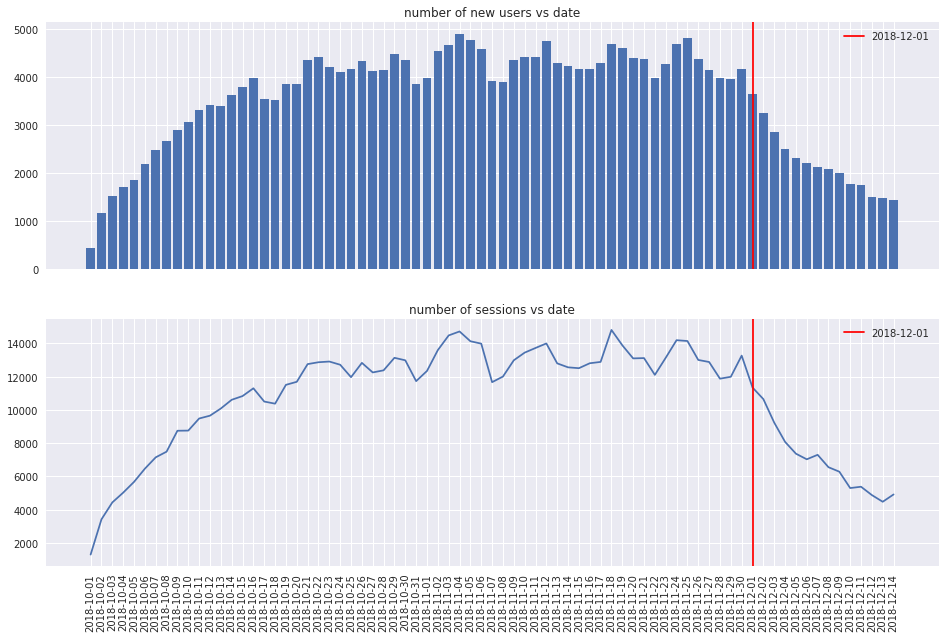

In [58]:
fig, (ax1, ax2) = plt.subplots(2, sharex=True, figsize=(16,10))
ax1.bar(x=purchase_num.event_date.tolist(),
        height=purchase_num.event.tolist())
handle1 = ax1.axvline('2018-12-01', color='r')
ax1.set_title(label='number of new users vs date')
ax1.legend([handle1], ['2018-12-01'])

ax2.plot(purchase_num['event_date'].tolist(), purchase_num['event_value'].tolist())
handle2 = ax2.axvline('2018-12-01', color='r')
ax2.tick_params(axis='x', rotation=90)
ax2.set_title(label='number of sessions vs date')
ax2.legend([handle2], ['2018-12-01'])
plt.show()

There is also a seasonal pattern when we look at the number of purchases and the amount of purchaes values.

In [59]:
purchase_num['avg_amt'] = purchase_num.event_value/purchase_num.event

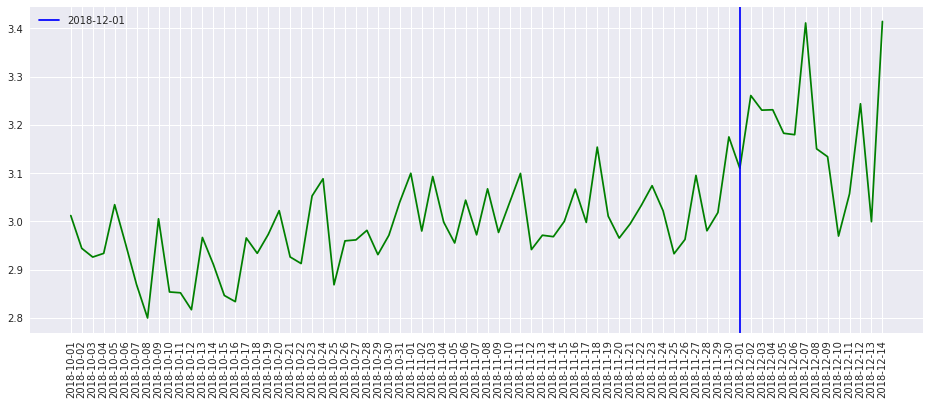

In [65]:
plt.figure(figsize=(16,6))
plt.plot(purchase_num.event_date.tolist(),
         purchase_num.avg_amt.tolist(), color='g')
plt.tick_params(axis='x', rotation=90)
handle = plt.axvline('2018-12-01', color='b')
plt.legend([handle], ['2018-12-01'])
plt.show()

### all categories of events

In [66]:
events_new.event.value_counts()[:20]

45                    75493931
1                      5363926
5                      4887922
6                      4068474
14                     3491117
4                      3435363
40                     2775997
7                      1970903
41                     1969223
3                      1828494
42                     1598212
.a5027911885258752      618037
.a5400102822346752      604699
44                      495590
.a5516611293544448      411053
0                       407118
63                      347198
47                      310038
57                      271268
8                       265034
Name: event, dtype: int64

## attributes

In [67]:
attributes_dtypes = {'session_code': np.uint32,
                     'attribute': np.uint8,
                     'attribute_value': 'category',
                     'user_code': np.uint32}

attributes_new = pd.read_csv('./newdata/attributes_new.csv', dtype=attributes_dtypes)

In [72]:
attributes_new.head(5)

,session_code,attribute,attribute_value,user_code
0,21760,0,2,617387
1,21760,1,0,617387
2,21760,3,0,617387
3,21760,4,0.48,617387
4,21760,5,romance_rules_of_engagement_03:7,617387


In [68]:
attributes_new.attribute.unique()

array([ 0,  1,  3,  4,  5,  6,  7,  8,  9, 10, 11, 13, 14, 15, 16, 17, 18,
       19, 20, 21, 52, 66, 67, 75, 76, 77, 78, 48, 96, 49], dtype=uint64)

In [70]:
attributes_new.attribute.value_counts()

16    6776351
15    6776351
1     6776351
3     6776351
4     6776351
5     6776351
6     6776351
7     6776351
8     6776351
9     6776351
10    6776351
11    6776351
13    6776351
14    6776351
0     6776351
17    6776351
18    6776351
19    6776351
20    6776351
21    6776351
52    6776351
75    6776297
76    6776297
77    6776297
78    6685459
66    6614104
48    6183014
67    3395545
96      79643
49         65
Name: attribute, dtype: int64